# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import os
import shutil
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output


import const as cst
from libs.pconv_model import PConvUnet
from libs.util import random_mask

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

BATCH_SIZE = 1

%load_ext autoreload
%autoreload 2
plt.ioff()

/home/ubuntu/anaconda3/envs/Pconv-Keras/lib/python3.6/site-packages/matplotlib/__init__.py:995: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/Pconv-Keras/lib/python3.6/site-packages/matplotlib/__init__.py:995: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Creating train & test data generator

In [3]:
class DataGenerator(ImageDataGenerator):
    def __init__(self, random_crop_size=None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        assert random_crop_size == None or len(random_crop_size) == 2
        self.random_crop_size = random_crop_size
        
    def has_many_mask(self, mask):
        height, width = mask.shape[0], mask.shape[1]
        masked_pixels = []

        for y in range(height):
            for x in range(width):
                if mask[y, x, 0] == 0: # 0: black
                    masked_pixels.append(mask[y, x, 0])

        if len(masked_pixels) != 0:
            # print("Rate: " + str(len(masked_pixels)/262144*100)) # 512x512=262,144
            return True

        return False

    def random_crop(self, ori, mask):
        assert ori.shape[3] == 3
        if ori.shape[1] < self.random_crop_size[0] or ori.shape[2] < self.random_crop_size[1]:
            raise ValueError(f"Invalid random_crop_size : original = {ori_img.shape}, crop_size = {self.random_crop_size}")

        height, width = ori.shape[1], ori.shape[2]
        dy, dx = self.random_crop_size
    
        recrop_cnt = -1        
        while True:
            recrop_cnt += 1
            x = np.random.randint(0, width - dx + 1)
            y = np.random.randint(0, height - dy + 1)

            # Check ratio of mask
            croped_ori = ori[:, y:(y+dy), x:(x+dx), :]
            croped_mask = mask[:, y:(y+dy), x:(x+dx), :]
            
            if self.has_many_mask(croped_mask[0]):
                break
        
        return croped_ori, croped_mask, recrop_cnt    
    
    
    
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)

        while True:
            ori = next(generator)
            ori_length = ori.shape[0]

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori_length)], axis=0)

            # Crop ori, mask and masked images
            croped_ori, croped_mask, recrop_cnt = self.random_crop(ori, mask)
            recrop_cnt += recrop_cnt

            # Apply masks to all image sample
            masked = deepcopy(croped_ori)
            masked[croped_mask == 0] = 1

            # Yield ([ori, masl],  ori) training batches
            gc.collect()
            
            print(masked.shape)
            print(croped_mask.shape)
            yield [masked, croped_mask], croped_ori
               


test_datagen = DataGenerator(
                    rescale=1./255,
                    random_crop_size=(cst.CROP_HEIGHT, cst.CROP_WIDTH))
test_generator = test_datagen.flow_from_directory(
                    '/mnt/PConv-Keras/house-dataset/test-crop-256-512',
                    target_size=(cst.CROP_HEIGHT, cst.CROP_WIDTH),
                    batch_size=BATCH_SIZE,
                    seed=1)

# test_datagen = DataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     ,
#     target_size=(cst.CROP_HEIGHT, cst.CROP_WIDTH),
#     batch_size=BATCH_SIZE,
#     seed=1
# )

# cst.MAX_HEIGHT, cst.MAX_WIDTH

# test_datagen = DataGenerator(
#                     rescale=1./255,
#                     random_crop_size=(cst.CROP_HEIGHT, cst.CROP_WIDTH))
# test_generator = test_datagen.flow_from_directory(
#                     cst.TEST_PATH,
#                     target_size=(cst.CROP_HEIGHT, cst.CROP_WIDTH),
#                     batch_size=BATCH_SIZE,
#                     seed=1)

In [4]:
blogkasdf

NameError: name 'blogkasdf' is not defined

In [ ]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

## Check 'nan' in weight

In [ ]:
# from libs.pconv_model import PConvUnet
# from keras.layers.wrappers import Wrapper
# from keras.layers import Dense, Dropout, Flatten, Input
# from keras.models import Model

# print(model.layers)
# print(type(model.layers))

# for layer in model.layers:
#     weights = layer.get_weights()
#     for weight in weights:
#         print(weight.shape)
#         if np.any(np.isnan(weight)):
#             print(layer.name)
#             print(weights)

## Create mask using weight made by multi GPU

In [ ]:
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512v2/20_weights_2018-11-07-14-33-30.h5',
    train_bn=False,
    lr=0.00005
)a

a

In [ ]:
# Masked, Predicted, Originalの画像をそれぞれ保存 by using PIL
from PIL import Image
import time
from datetime import datetime

# Create dir
start = time.time()
filename = datetime.now().strftime("%Y%m%d_%H%M")
print("Start: " + str(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

dir_name = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
dir_path = '/mnt/PConv-Keras/output_sample/' + dir_name
os.makedirs(dir_path)

n = 0

for (masked, mask), ori in tqdm(test_generator):
    masked = cv2.resize(masked[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    mask = cv2.resize(mask[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    ori = cv2.resize(ori[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
            
    # Clear current output and display test images
    for i in range(len(ori)):
        mask_image = Image.fromarray(np.uint8(masked[i,:,:,:]*255))
        pred_image = Image.fromarray(np.uint8((pred_img[i,:,:,:]*1.*255)))
        ori_image  = Image.fromarray(np.uint8(ori[i,:,:,:]*255))
#         print(pred_img)
#         print(pred_img.mean())        
#         print(np.uint8((pred_img[i,:,:,:]*1.)*255))
                
        save_mask_path = '/mnt/PConv-Keras/output_sample/{}/{}_masked_img_{}.png'.format(dir_name, pred_time, i)
        save_pred_path = '/mnt/PConv-Keras/output_sample/{}/{}_predicted_img_{}.png'.format(dir_name, pred_time, i)
        save_ori_path  = '/mnt/PConv-Keras/output_sample/{}/{}_original_img_{}.png'.format(dir_name, pred_time, i)
        
        mask_image.save(save_mask_path)
        pred_image.save(save_pred_path)
        ori_image.save(save_ori_path)

        n += 1        
        
    # Only create predictions for about 100 images
    if n > 5:
        break
        
        
elapsed_time = time.time() - start            
print("Elapsed_time:{0}".format(elapsed_time) + "[sec]")        

In [ ]:
a

# Training on PIXNET Food 20. It's only for demo. Please use Command Line

In [ ]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig('{}/data/output_samples/img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [ ]:
# Instantiate the model
model = PConvUnet(weight_filepath='data/model/')
model.load("/mnt/PConv-Keras/data/model/3_weights_2018-09-23-17-22-33.h5")

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=10000,
    validation_data=val_generator,
    validation_steps=100,
    epochs=50,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='../data/logs/initial_training', write_graph=False)
    ]
)

## Phase 2 - without batch normalization

In [ ]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    '{}/data/model/weight-256-512/3000_weights_2018-10-07-05-52-50.h5'.format(cst.MNT_PATH),
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=3,
    validation_data=val_generator,
    validation_steps=100,
    epochs=1,        
    workers=3,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='../data', write_graph=False)
    ]
)

## Phase 3 - Generating samples

In [ ]:
# # Load weights from previous run
print(cst.MAX_HEIGHT)
print(cst.MAX_WIDTH)

model = PConvUnet(
    img_rows=cst.MAX_HEIGHT,
    img_cols=cst.MAX_WIDTH,
    weight_filepath='data/model/')

# model = PConvUnet(weight_filepath='data/model/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-crop-512-1024/1_weights_2018-10-27-05-22-52.h5',
    train_bn=False,
    lr=0.00005
)


# model.load(
#     '/mnt/PConv-Keras/data/model/weight-256-512/3000_weights_2018-10-07-05-52-50.h5',
#     train_bn=False,
#     lr=0.00005
# )

# You need to name weight "<Num>_weights_<Year>-<Month>-<Day>-<Time>.h5

In [ ]:
# Masked, Predicted, Originalの画像をそれぞれ保存 by using PIL
from PIL import Image
import time
from datetime import datetime

# Create dir
filename = datetime.now().strftime("%Y%m%d_%H%M")
print("Start: " + str(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

dir_name = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
dir_path = '/mnt/PConv-Keras/output_sample/' + dir_name
os.makedirs(dir_path)

n = 0

for (masked, mask), ori in tqdm(test_generator):
#     print(mask.shape)
    masked = cv2.resize(masked[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    mask = cv2.resize(mask[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    ori = cv2.resize(ori[0], (cst.MAX_WIDTH, cst.MAX_HEIGHT))[np.newaxis, ...]
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])/255
    pred_time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
            
    # Clear current output and display test images
    for i in range(len(ori)):
        mask_image = Image.fromarray(np.uint8(masked[i,:,:,:]*255))
        pred_image = Image.fromarray(np.uint8((pred_img[i,:,:,:] * 1.)*255))
        print()
        ori_image  = Image.fromarray(np.uint8(ori[i,:,:,:]*255))
                
        save_mask_path = '/mnt/PConv-Keras/output_sample/{}/{}_masked_img_{}.png'.format(dir_name, pred_time, i)
        save_pred_path = '/mnt/PConv-Keras/output_sample/{}/{}_predicted_img_{}.png'.format(dir_name, pred_time, i)
        save_ori_path  = '/mnt/PConv-Keras/output_sample/{}/{}_original_img_{}.png'.format(dir_name, pred_time, i)
        
        mask_image.save(save_mask_path)
        pred_image.save(save_pred_path)
        ori_image.save(save_ori_path)

        n += 1        
        
    # Only create predictions for about 100 images
    if n > 30:
        break
        
        
elapsed_time = time.time() - start            
print("Elapsed_time:{0}".format(elapsed_time) + "[sec]")        

In [ ]:
# Masked, Predicted, Originalの画像をそれぞれ保存 by using matplotlib
n = 0


def plot_setting_and_save(save_filename):
    axes.tick_params(labelbottom="off",bottom="off") # delete x axes
    axes.tick_params(labelleft="off",left="off") # delete y axes        
    plt.gca().spines['top'].set_visible(False) # delete axis spines
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)        
    axes.set_xticklabels([])
    
    plt.savefig(save_filename, bbox_inches="tight", pad_inches=0)    
    plt.close()


for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        # Save masked image        
        _, axes = plt.subplots()
        axes.imshow(masked[i,:,:,:])        
        save_filename = '{}/data/output_samples/masked_img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time)
        plot_setting_and_save(save_filename)
        
        # Save predicted image
        _, axes = plt.subplots()
        axes.imshow(pred_img[i,:,:,:] * 1.)
        save_filename = '{}/data/output_samples/predicted_img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time)
        plot_setting_and_save(save_filename)
        
        # Save original image
        _, axes = plt.subplots()
        axes.imshow(ori[i,:,:,:])
        save_filename = '{}/data/output_samples/original_img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time)
        plot_setting_and_save(save_filename)
        
        # plt.show()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 1:
        break

In [ ]:
# Mask, Predicted Original を1枚の画像に保存
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(30, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
        
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
        axes[2].xaxis.set_major_formatter(NullFormatter())
        axes[2].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig('{}/data/output_samples/img_{}_{}.png'.format(cst.MNT_PATH, i, pred_time))
        plt.close()
        n += 1        
        
    # Only create predictions for about 100 images
    if n > 1:
        break

## 任意のマスク画像を用いて画像生成

In [ ]:
# Load weights from previous run
# Need to name weight "<Num>_weights_<Year>-<Month>-<Day>-<Time>.h5

# 256x512
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-256x512/19_weights_2018-11-01-10-10-40.h5

# 256x512
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x512v2/19_weights_2018-11-09-06-34-40.h5

# 512x512 mask -> crop
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512/15_weights_2018-11-05-09-45-58.h5

# 512x512 crop -> mask
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512v2/20_weights_2018-11-07-14-33-30.h5

# 512x512 mask->crop
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_mask-30-50/17_weights_2018-11-12-11-53-36.h5

model = PConvUnet(weight_filepath='data/model/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x512v2/19_weights_2018-11-09-06-34-40.h5',
    train_bn=False,
    lr=0.00005
)

In [ ]:
# masked = cv2.imread('/mnt/PConv-Keras/sample_images/blackmask_1536x3072.png')
masked = cv2.imread('/mnt/PConv-Keras/sample_images/mask_1536x3072.png')
ori    = cv2.imread('/mnt/PConv-Keras/sample_images/ori_1536x3072.png')

# # Resize for test(256x512)
# masked = cv2.resize(masked, (512, 256))
# ori    = cv2.resize(ori, (512, 256))
    
# cv2.imwrite("/nfs/host/PConv-Keras/sample_images/masked.jpg", masked)
# cv2.imwrite("/nfs/host/PConv-Keras/sample_images/ori.jpg", ori)

masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB) # 青みがかってしまうのでRGBに変更
ori    = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)

img_diff = cv2.absdiff(ori, masked)
mask = cv2.threshold(img_diff, 5, 255, cv2.THRESH_BINARY_INV)[1] # 2値化

In [ ]:
# 4階テンソルにして、0〜1の間に値を収める(こうしないと真っ黒なpredicted画像が出力される)
mask   = mask[np.newaxis, ...]/255   # mask.reshape((1, 256, 512, 3))
masked = masked[np.newaxis, ...]/255 # masked.reshape((1, 256, 512, 3))

# cv2.imwrite("/nfs/host/PConv-Keras/sample_images/mask_256_512.jpg", mask[0]) # 3階のテンソルにする
# cv2.imwrite("/nfs/host/PConv-Keras/sample_images/masked_256_512.jpg", masked[0]) # 3階のテンソルにする

In [ ]:
# 標準的な推論方法
from PIL import Image
from datetime import datetime

pred_img = model.predict([masked, mask])
pred_time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

pred_image = Image.fromarray(np.uint8((pred_img[0,:,:,:] * 1.)*255))
save_pred_path = '/mnt/PConv-Keras/sample_images/predicted_image_black.jpg'.format(pred_time)
pred_image.save(save_pred_path)

# 推論方法の変更

In [ ]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmented image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1
            
            print(ori.shape)
            print(mask.shape)
            

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

            
# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    cst.TEST_PATH,
    target_size=(32, 32),
    batch_size=BATCH_SIZE,
    seed=1
)

# cst.MAX_HEIGHT, cst.MAX_WIDTH
# 20, 20

In [ ]:
from libs.pconv_model import PConvUnet

model = PConvUnet(weight_filepath='data/model/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x512v2/19_weights_2018-11-09-06-34-40.h5',
    train_bn=False,
    lr=0.00005
)

In [ ]:
from PIL import Image
from datetime import datetime

import cv2
import numpy as np

# Read image
ori    = cv2.imread('/mnt/PConv-Keras/sample_images/ori_1536x3072.png')
masked = cv2.imread('/mnt/PConv-Keras/sample_images/mask_1536x3072.png')

# 青みがかってしまうのでRGBに変更
masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB) 
ori    = cv2.cvtColor(ori, cv2.COLOR_BGR2RGB)

# Create mask image
img_diff = cv2.absdiff(ori, masked)
mask = cv2.threshold(img_diff, 5, 255, cv2.THRESH_BINARY_INV)[1] # Binarization

# Get contours
img_diff = cv2.cvtColor(img_diff, cv2.COLOR_BGR2GRAY) # Convert to CV_8UC1
binary_inv_mask = cv2.threshold(img_diff, 5, 255, cv2.THRESH_BINARY_INV)[1] # Binarization for findContours
binary_mask = cv2.threshold(img_diff, 5, 255, cv2.THRESH_BINARY)[1] # Binarization for findContours
_, contours, _ = cv2.findContours(binary_inv_mask, 1, 2)

mask   = mask[np.newaxis, ...]/255   # mask.reshape((1, 256, 512, 3))
masked = masked[np.newaxis, ...]/255 

print(len(contours))
print(mask.shape)

In [ ]:
def plot_contours(axes, img, contours):
    from matplotlib.patches import Polygon
    axes.imshow(img)
    axes.axis('off')
    for i, cnt in enumerate(contours):
        cnt = np.squeeze(cnt)             
        axes.add_patch(Polygon(cnt, fill=None, lw=1., color='r')) # 点同士を結ぶ線を描画        
        axes.text(cnt[0][0], cnt[0][1], i, color='orange', size='20') # 輪郭の番号を描画
        

        
def plot_img(axes, img):
    from matplotlib.patches import Polygon
    axes.imshow(img)
    axes.axis('off')

def draw_contours(axes, img, contours):
    from matplotlib.patches import Polygon
    axes.imshow(img)
    axes.axis('off')
    for i, cnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cnt)
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)        
        print(str(i) + ": " + str(x) + ", " + str(y) + ", " + str(w) + ", " + str(h))
                    
    cv2.imwrite("/mnt/PConv-Keras/sample_images/" + str(i) + '.jpg', img)

## マスク部分を囲み、その一部分に対してのみ推論をかけていく

In [ ]:
def recursive_predict(masked, mask, contours):
    edge = 20
    stride = 10
    
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        
        loop_x = int(w/stride) + 1
        loop_y = int(h/stride) + 1        
        print("loop_x:" + str(loop_x) + ", loop_y:" + str(loop_y))
        
        for i in range(loop_x):        
            for j in range(loop_y): 
                print(str(i) + " - " + str(j))
                print("x:" + str(x) + ", y:" + str(y))
                
                upper_left_x = x - int(edge/2)
                upper_left_y = y - int(edge/2)
                bottom_right_x = x + int(edge/2)
                bottom_right_y = y + int(edge/2)
                
                croped_masked = masked[:, upper_left_y:bottom_right_y, upper_left_x:bottom_right_x]
                croped_mask = mask[:, upper_left_y:bottom_right_y, upper_left_x:bottom_right_x]
                print(croped_masked.shape)
                
                # You need to use image size of at least 256x256
                croped_pred = model.predict([croped_masked, croped_mask])
                
                masked[upper_left_y:bottom_right_y, upper_left_x:bottom_right_x] = croped_pred # Overlay for update image
                
                x += stride
                y += stride       
                
    recursive_predict_masked = Image.fromarray(np.uint8(masked[i,:,:,:]*255))                
    recursive_predict_masked.save('/mnt/PConv-Keras/sample_images/recursive_predict_masked.png')


# recursive_predict(masked, mask, contours)

In [ ]:
# Show and Save image
# _, axes = plt.subplots(1, 1, figsize=(20, 5))
# axes.imshow(mask)
# plt.show()
# save_ori = Image.fromarray(masked)
# save_ori.save("/mnt/PConv-Keras/sample_images/save.jpg")


# Show mask image
# fig, axes = plt.subplots(figsize=(10, 10))
# axes.imshow(mask)
# axes.axis('off')
# plt.show()


# Show boxed mask image
fig, axes = plt.subplots(figsize=(10, 10))
plot_contours(axes, masked[0], contours)
plt.show()


# Save image
# draw_contours(axes, mask[0], contours)

## マスク部分の外側から推論していき、その範囲を徐々に狭めていく
#### ※全マスク部分に対して同時に推論をかけていく

In [ ]:
# 256x512 crop->mask
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-256x512/19_weights_2018-11-01-10-10-40.h5

# 256x512 mask->crop
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x512v2/19_weights_2018-11-09-06-34-40.h5

# 512x512 mask -> crop
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512/15_weights_2018-11-05-09-45-58.h5

# 512x512 crop -> mask
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512v2/20_weights_2018-11-07-14-33-30.h5

# 512x512 mask->crop(30-50%)
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_mask-30-50/17_weights_2018-11-12-11-53-36.h5

# 512x512 mask->crop(exclude no-mask image)
# /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_exclude_nomask/14_weights_2018-11-17-15-00-15.h5

from PIL import Image
from datetime import datetime
import cv2
import numpy as np
from libs.pconv_model import PConvUnet

# Load model
model = PConvUnet(weight_filepath='data/model/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_mask-30-50/17_weights_2018-11-12-11-53-36.h5',
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Load image 
ori_img    = cv2.imread('/mnt/PConv-Keras/sample_images/ori_1536x3072.png')
masked_img = cv2.imread('/mnt/PConv-Keras/sample_images/mask_1536x3072.png')

# 青みがかってしまうのでRGBに変更
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB) 

# Create mask image
# ori_and_masked_img_diff = cv2.absdiff(ori_img, masked_img)
# mask_img = cv2.threshold(ori_and_masked_img_diff, 5, 255, cv2.THRESH_BINARY)[1]
# mask_inv_img = cv2.threshold(ori_and_masked_img_diff, 5, 255, cv2.THRESH_BINARY_INV)[1]


# Create mask image
mask_img = (np.sum(masked_img, axis = -1) == 255 * 3) * 255 # shape: (1536, 3072)
mask_img = cv2.threshold(mask_img, 5, 255, cv2.THRESH_BINARY_INV)[1]
mask_img = np.repeat(mask_img[..., np.newaxis], 3, axis=2) # shape: (1536, 3072, 3)
mask_inv_img = 255 - mask_img


# Get contours
ori_and_masked_img_diff = cv2.absdiff(ori_img, masked_img)
gray_img_diff = cv2.cvtColor(ori_and_masked_img_diff, cv2.COLOR_BGR2GRAY) # Convert to CV_8UC1
# binary_inv_mask = cv2.threshold(ori_and_masked_img_diff, 5, 255, cv2.THRESH_BINARY_INV)[1]
# binary_mask = cv2.threshold(ori_and_masked_img_diff, 5, 255, cv2.THRESH_BINARY)[1]
_, contours, _ = cv2.findContours(gray_img_diff, 1, 2)

# Resize for prediction
ori_tensor = ori_img[np.newaxis, ...]/255
masked_tensor = masked_img[np.newaxis, ...]/255
mask_tensor = mask_img[np.newaxis, ...]/255
mask_inv_tensor = mask_inv_img[np.newaxis, ...]/255

# masked_tensor(0~1)  : White painted Original image. Used for prediction
# mask_tensor(0~1)    : Part of mask is white(=1)
# mask_inv_tensor(0~1): Part of mask is black(=0). Used for prediction

In [ ]:
print(mask_inv_tensor.shape)

fig, axes = plt.subplots(figsize=(10, 10))
plot_contours(axes, masked_tensor[0], contours)
plt.show()

fig, axes = plt.subplots(figsize=(10, 10))
plot_contours(axes, mask_inv_tensor[0], contours)
plt.show()

print(masked_tensor.shape)
print(mask_tensor.shape)

fig, axes = plt.subplots(figsize=(10, 10))
plot_contours(axes, mask_tensor[0], contours)
plt.show()

In [ ]:
from PIL import Image

pred_img = model.predict([masked_tensor, mask_inv_tensor])

pred_image = Image.fromarray(np.uint8((pred_img[0,:,:,:] * 1.)*255))
pred_image.save('/mnt/PConv-Keras/sample_images/weight-crop-512x512_mask-30-50_normal_x.jpg')

In [ ]:
kernel = np.ones((200, 200),np.uint8)

model_input_img_tensor = masked_tensor
model_input_mask_tensor = mask_inv_tensor 

for i in range(1):
    save_img = Image.fromarray(np.uint8((model_input_img_tensor[0,:,:,:] * 1.) * 255))
    save_path = '/mnt/PConv-Keras/sample_images/weight-crop-512x512v2_{}.jpg'.format(i)
    save_img.save(save_path)
     
    # Prediction
    model_output = model.predict([model_input_img_tensor, model_input_mask_tensor])
    
    _, axes = plt.subplots(figsize=(15, 15))
    plot_contours(axes, model_input_mask_tensor[0], contours)
    plt.show()
    
    # Update image
    new_mask_tensor = cv2.dilate(model_input_mask_tensor[0], kernel, iterations=1)[np.newaxis, ...] # 黒背景で白マスクの箇所を小さくする

    new_img_tensor = (
        (model_input_img_tensor * model_input_mask_tensor) + (model_output * (1-model_input_mask_tensor))
    )  * new_mask_tensor

    model_input_img_tensor = new_img_tensor
    model_input_mask_tensor = new_mask_tensor
                            
    print("Saved")    
    
    # print(model_output == new_img_tensor)
    
    
    """
    print("マスクされた画像")
    _, axes = plt.subplots(figsize=(15, 15))
    plot_contours(axes, pred_masked_tensor[0], contours)
    plt.show()    
    print("マスクのみの画像")
    _, axes = plt.subplots(figsize=(15, 15))
    plot_contours(axes, pred_mask_inv_tensor[0], contours)
    plt.show()       
    print("推論された画像")
    _, axes = plt.subplots(figsize=(15, 15))
    plot_contours(axes, pred_img[0], contours)
    plt.show()
    """ 

In [ ]:
# pred_img = model.predict([pred_masked_tensor, pred_mask_inv_tensor])
print(pred_img[0].shape)
print(eroded_mask_img.shape)
print(type(pred_img))
print(type(eroded_mask_img))
# print(pred_img)

In [ ]:
    _, axes = plt.subplots(figsize=(10, 10))
    plot_contours(axes, pred_masked_tensor[0], contours)
    plt.show()
    
    _, axes = plt.subplots(figsize=(10, 10))
    plot_contours(axes, ((pred_mask_inv_tensor[0]*255).astype(np.uint8), contours)
    plt.show()
       

# 推論した際にモデルの色調が変わらないように、2つの画像の差分箇所だけを変更するようにする


## 256x512 crop->mask
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-256x512/19_weights_2018-11-01-10-10-40.h5

## 256x512 mask->crop
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x512v2/19_weights_2018-11-09-06-34-40.h5

## 512x512 mask -> crop
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512/15_weights_2018-11-05-09-45-58.h5

## 512x512 crop -> mask
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512v2/20_weights_2018-11-07-14-33-30.h5  
40h /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512v2/33_weights_2018-11-08-07-48-45.h5  

## 512x512 mask->crop(30-50%)
40h /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_mask-30-50/10_weights_2018-11-11-07-21-06.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_mask-30-50/17_weights_2018-11-12-11-53-36.h5  
 

## 512x512 mask->crop(exclude no-mask image)
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_exclude_nomask/14_weights_2018-11-17-15-00-15.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_exclude_nomask/27_weights_2018-11-19-12-15-31.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-512x512_exclude_nomask/34_weights_2018-11-20-13-24-36.h5  

## 768x768(bathsize=4) on GCP
✕　/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-768x768_exclude_nomask/39_weights_2018-11-24-00-39-08.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-768x768_exclude_nomask/4_weights_2018-11-25-07-51-01.h5  
40h /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-768x768_exclude_nomask/6_weights_2018-11-25-20-44-31.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-768x768_exclude_nomask/7_weights_2018-11-28-05-32-24.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-768x768_exclude_nomask/15_weights_2018-11-30-04-05-31.h5  
150h /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-768x768_exclude_nomask/25_weights_2018-12-04-02-07-29.h5  

## 256x256(bathsize=4) on Spacely
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256_exclude_nomask/5_weights_2018-11-24-12-15-14.h5  
40h /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256_exclude_nomask/11_weights_2018-11-25-13-42-38.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256_exclude_nomask/16_weights_2018-11-26-07-51-57.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256_exclude_nomask/20_weights_2018-11-27-16-01-48.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256_exclude_nomask/26_weights_2018-11-28-13-48-02.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256_exclude_nomask/31_weights_2018-11-29-08-16-20.h5  
/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256_exclude_nomask/39_weights_2018-11-30-13-18-22.h5  
145h(150) /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256_exclude_nomask/40_weights_2018-11-30-16-55-42.h5  

## 256x256(bathsize=7) on Spacely
40h /mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256-batch-7/12_weights_2018-12-02-13-05-14.h5  


In [13]:
from PIL import Image
from datetime import datetime
import cv2
import numpy as np
from libs.pconv_model import PConvUnet

# Load model
model = PConvUnet(weight_filepath='data/model/')
model.load(
    '/mnt/PConv-Keras/data/model/weight-resize-1536x3072/weight-crop-256x256-batch-7/12_weights_2018-12-02-13-05-14.h5',
    train_bn=False,
    lr=0.00005
)

1536
3072


In [7]:
def plot_contours(axes, img, contours):
    from matplotlib.patches import Polygon
    axes.imshow(img)
    axes.axis('off')
    for i, cnt in enumerate(contours):
        cnt_sq = np.squeeze(cnt)
#         cv2.fillConvexPoly(img, cnt, 255) # np.array(cnt)
        axes.add_patch(Polygon(cnt_sq, fill=None, lw=0.5, color='r')) # 点同士を結ぶ線を描画        
        axes.text(cnt_sq[0][0], cnt_sq[0][1], i, color='orange', size='20') # 輪郭の番号を描画       
    
def plot_img(axes, img):
    from matplotlib.patches import Polygon
    axes.imshow(img)
    axes.axis('off')

def draw_contours(axes, img, contours):
    from matplotlib.patches import Polygon
    axes.imshow(img)
    axes.axis('off')
    for i, cnt in enumerate(contours):
        x,y,w,h = cv2.boundingRect(cnt)
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)        
        print(str(i) + ": " + str(x) + ", " + str(y) + ", " + str(w) + ", " + str(h))
                    
    cv2.imwrite("/mnt/PConv-Keras/sample_images/" + str(i) + '.jpg', img)

/mnt/PConv-Keras/sample_images/test_imgs/panel_05_gray.jpg


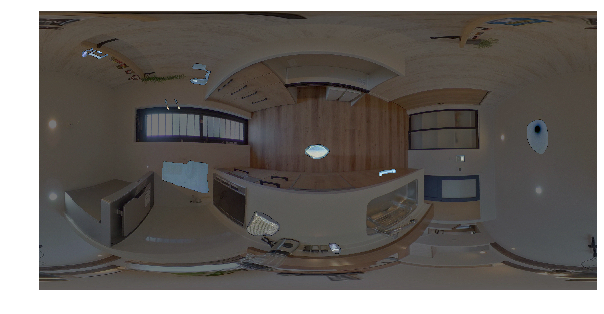

/mnt/PConv-Keras/sample_images/test_imgs/panel_06_gray.jpg


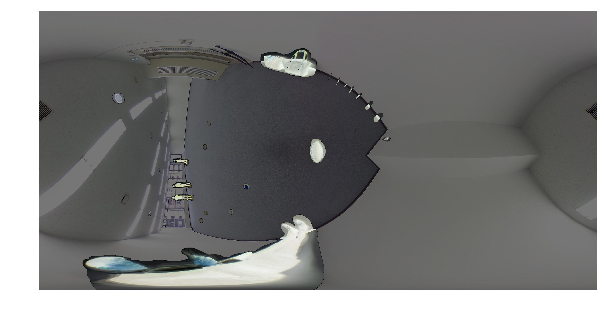

/mnt/PConv-Keras/sample_images/test_imgs/panel_07_gray.jpg


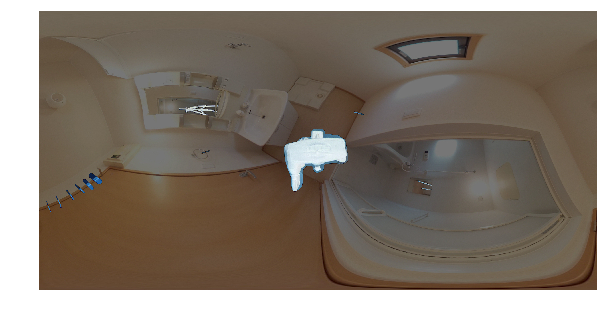

/mnt/PConv-Keras/sample_images/test_imgs/panel_08_gray.jpg


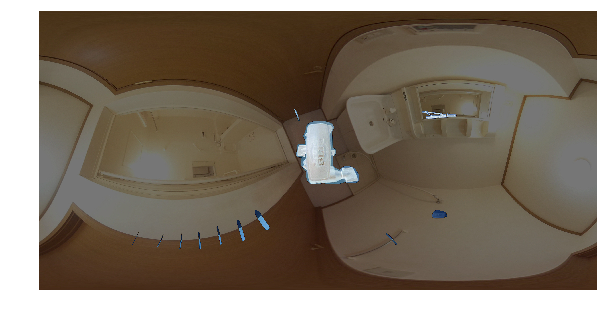

/mnt/PConv-Keras/sample_images/test_imgs/panel_09_gray.jpg


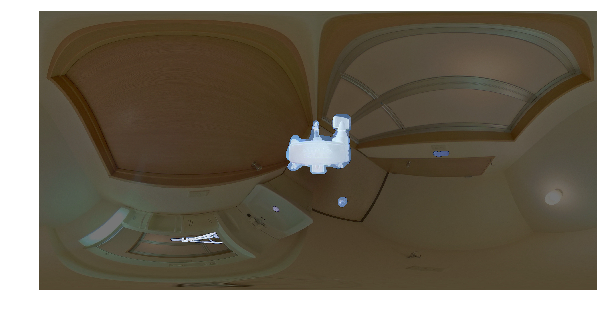

In [14]:
from PIL import Image
import time
from datetime import datetime

sample_img_path = '/mnt/PConv-Keras/sample_images'

#
# Create save filename
# 
CROP_SIZE     = '768x768'
GPU_SIZE      = 'GPU-4'
BATCH_SIEZE   = 'Batch-7'
EPOCH         = 'Epoch-12'
LEARNING_TIME = 'Time-40h'

# ex) 256x256_GPU-4_Batch-4_Epoch-11_Time-40h
save_filename = ('_').join((CROP_SIZE, GPU_SIZE, BATCH_SIEZE, EPOCH, LEARNING_TIME))

#
# Create dir
#
dir_name = datetime.now().strftime('%Y%m%d_%H%M%S')
save_dir_path = sample_img_path + '/' + dir_name
os.makedirs(save_dir_path)


for i in range(5):
    #
    # Load image 
    #
    i += 5
    print('{}/test_imgs/panel_0{}_gray.jpg'.format(sample_img_path, i))
    ori_img    = cv2.imread('{}/test_imgs/panel_0{}_gray.jpg'.format(sample_img_path, i))
    masked_img = cv2.imread('{}/test_imgs/panel_0{}_mask.jpg'.format(sample_img_path, i))       

    # 青みがかってしまうのでRGBに変更
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB)

    #
    # Create mask image
    #
    img_diff = cv2.absdiff(ori_img, masked_img)
    fig, axes = plt.subplots(figsize=(10, 10))
    plot_img(axes, img_diff)
    plt.show()
    
    mask = np.concatenate([((np.sum(masked_img, axis = -1) > 200 * 3) * 255)[..., np.newaxis]] * 3, axis = -1)
    mask_inv_img = 255 - mask

    #
    # Load original color image
    # 
    ori_img_color = cv2.imread('{}/test_imgs/panel_0{}_ori.jpg'.format(sample_img_path, i))
    ori_img_color = cv2.cvtColor(ori_img_color, cv2.COLOR_BGR2RGB)

    #
    # Resize for prediction
    #
    gray_ori_tensor = ori_img[np.newaxis, ...]/255
    masked_tensor = ori_img_color[np.newaxis, ...]/255.
    mask_inv_tensor = mask_inv_img[np.newaxis, ...]/255
    
    
    #
    # Prediction
    #
    model_input_img_tensor = masked_tensor
    model_input_mask_tensor = mask_inv_tensor 

    model_output = model.predict([model_input_img_tensor, model_input_mask_tensor])

    save_img = (model_input_img_tensor * model_input_mask_tensor) + model_output * (1-model_input_mask_tensor)
    save_img = Image.fromarray(np.uint8((save_img[0,:,:,:] * 1.)*255))
    save_img.save('{}/{}_0{}.jpg'.format(save_dir_path, save_filename, i))
                

In [ ]:
#
# Get contours
#

# ori_and_masked_img_diff = cv2.absdiff(ori_img, masked_img)
# gray_img_diff = cv2.cvtColor(ori_and_masked_img_diff, cv2.COLOR_BGR2GRAY) # Convert to CV_8UC1
# binary_inv_mask = cv2.threshold(gray_img_diff, 40, 128, cv2.THRESH_BINARY_INV)[1] # Binarization for findContours
# _, contours, _ = cv2.findContours(binary_inv_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # 1,2
# 
# fig, axes = plt.subplots(figsize=(10, 10))
# plot_img(axes, binary_inv_mask)
# plt.show()
# 
# fig, axes = plt.subplots(figsize=(10, 10))
# plot_contours(axes, mask_inv_img, contours)
# plt.show()

In [ ]:
# from PIL import Image

# pred_img = model.predict([masked_tensor, mask_inv_tensor])

# pred_image = Image.fromarray(np.uint8(np.clip(pred_img[0,:,:,:] * 255., 0, 255)))
# pred_image.save('/mnt/PConv-Keras/sample_images/256x256(batchsize=7)_12_1_delete.jpg')